In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [60]:
df_import = pd.read_csv('arquivos\dadosalunos-limpo.csv')

C:\Users\romul\AppData\Local\Temp\ipykernel_20884\3102232277.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_import = pd.read_csv('arquivos\dadosalunos-limpo.csv')


In [61]:
df_import.columns

Index(['ANO_OCORRENCIA', 'CD_ALUNO', 'CD_CURSO', 'CD_ORIGEM_ALUNO', 'CD_TURNO',
       'DE_NATURALIDADE', 'DH_MATRICULA', 'DH_SITUACAO', 'DT_ANO_INGRES',
       'DT_NASC_ALUNO', 'LT_ESTADO_CIVIL', 'LT_MODALIDADE', 'LT_NACIONALIDADE',
       'LT_RACA', 'NM_CIDADE_AULA', 'NM_CIDADE_EST2GRAU', 'NM_CIDADE_FERIAS',
       'NM_CIDADE_NASC', 'NM_PAIS_NASC', 'NU_SEMESTRE2_VEST', 'SG_SEXO_ALUNO',
       'SG_UF_AULA', 'SG_UF_EST2GRAU', 'SG_UF_FERIAS', 'SG_UF_NASC_ALUNO',
       'ST_ALUNO', 'TP_DEFIC_INEP', 'TP_ESCOLA', 'TP_INGRES_CURSO',
       'TP_OPCAO_COTAS', 'F_CD_ORIGEM_ALUNO', 'F_DT_NASC_ALUNO',
       'F_NM_PAIS_NASC', 'F_NU_SEMESTRE2_VEST', 'F_SG_UF_FERIAS',
       'F_SG_UF_NASC_ALUNO', 'BOOL_TRANCADO', 'BOOL_ST_ALUNO',
       'MULTI_ST_ALUNO', 'BOOL_DEFIC_INEP', 'F_TP_ESCOLA', 'F_TP_OPCAO_COTAS',
       'BOOL_COTAS', 'IDADE_MATRICULA', 'ANO_NASCIMENTO',
       'MESES_ATE_ULTIMA_SITUACAO', 'NM_CURSO', 'TP_HABILITACAO', 'SG_CENTRO',
       'NM_CAMPUS', 'MAX_ANOS', 'BOOL_SEDE', 'LOCAL_FERI

In [62]:
colunas_excluir_ml = ['NM_CAMPUS', 
                      'SG_CENTRO', 
                      'NM_CURSO',
                      'GERACAO_COMPLETA', 
                      'NUMERO_GERACAO', 
                      'BOOL_ST_ALUNO', 
                      'MULTI_ST_ALUNO']
colunas_ml = ['CD_CURSO',
         'CD_TURNO',
         'LT_ESTADO_CIVIL',
         'LT_RACA',
         'F_NU_SEMESTRE2_VEST',
         'SG_SEXO_ALUNO',
         'BOOL_DEFIC_INEP',
         'F_TP_ESCOLA',
         'BOOL_COTAS',
         'IDADE_MATRICULA',
         'LOCAL_FERIAS',
         'LOCAL_NASC']
target_bool = 'BOOL_ST_ALUNO'
target_multi = 'MULTI_ST_ALUNO'

In [63]:
df = df_import[colunas_ml + colunas_excluir_ml].copy()

In [64]:
df = df.dropna()
df.shape[0]

66820

### Preparação do Dataset

In [65]:
pd.cut(df['IDADE_MATRICULA'], bins=[0, 16, 18, 20, 22, 24, 26, 30, 40, 50, 60, 70]).value_counts()

IDADE_MATRICULA
(16, 18]    36249
(18, 20]    14251
(20, 22]     5671
(22, 24]     3226
(26, 30]     2130
(24, 26]     1879
(30, 40]     1786
(0, 16]       935
(40, 50]      554
(50, 60]      128
(60, 70]       10
Name: count, dtype: int64

In [66]:
df['IDADE_MATRICULA'] = pd.cut(df['IDADE_MATRICULA'], bins=[0, 16, 18, 20, 22, 24, 26, 30, 40, 50, 60, 70]).value_counts()

In [67]:
from sklearn.preprocessing import LabelEncoder

In [68]:
for coluna in colunas_ml:
    le = LabelEncoder()
    df[coluna] = le.fit_transform(df[coluna])

In [69]:
df.shape[0]

66820

#### Jubilados antes do tempo mínimo

In [14]:
df_import[df_import['GERACAO_COMPLETA'] == 0]['MULTI_ST_ALUNO'].value_counts()

MULTI_ST_ALUNO
CANCELAMENTO     9010
MATRICULADO      8645
FORMADO          6562
TRANSFERENCIA     185
JUBILADO          169
Name: count, dtype: int64

In [113]:
df_import['DT_ANO_INGRES'].value_counts().sort_index()

DT_ANO_INGRES
2002    2202
2003    2725
2004    2751
2005    2845
2006    3007
2007    3186
2008    4066
2009    4085
2010    3512
2011    3567
2012    3379
2013    3519
2014    3373
2015    3214
2016    2932
2017    3036
2018    3148
2019    3110
2020    3282
2021    2945
2022    2936
Name: count, dtype: int64

In [111]:
df_import[(df_import['GERACAO_COMPLETA'] == 0) & (df_import['MULTI_ST_ALUNO'] == 'JUBILADO')]['DT_ANO_INGRES'].value_counts()

DT_ANO_INGRES
2015    55
2016    37
2017    26
2019    20
2018    13
2014    11
2020     5
2021     2
Name: count, dtype: int64

In [107]:
df_import['ANO_ULTIMA_SITUACAO'] = pd.to_datetime(df_import['DH_SITUACAO']).apply(lambda x: x.year)

In [115]:
df_import['ANO_ULTIMA_SITUACAO'].value_counts().sort_index()

ANO_ULTIMA_SITUACAO
2002    1700
2003    1097
2004     421
2005     212
2006      75
2007     808
2008    3649
2009    3613
2010    4864
2011    3781
2012    2122
2013    4077
2014    3209
2015    3415
2016    3214
2017    3499
2018    3653
2019    4302
2020    4690
2021    5240
2022    5828
2023    3351
Name: count, dtype: int64

In [117]:
df_import[df_import['ANO_ULTIMA_SITUACAO'] == 2023]['MULTI_ST_ALUNO'].value_counts()

MULTI_ST_ALUNO
FORMADO          1603
CANCELAMENTO     1172
MATRICULADO       429
JUBILADO          100
TRANSFERENCIA      47
Name: count, dtype: int64

### Funções

In [50]:
def oversample(x_train, y_train):
    smote = SMOTE(random_state=42)
    x_train_res, y_train_res = smote.fit_resample(x_train, y_train)
    return x_train_res, y_train_res

def undersample(x_train, y_train):
    rus = RandomUnderSampler(random_state=42)
    x_train_res, y_train_res = rus.fit_resample(x_train, y_train)
    return x_train_res, y_train_res

In [16]:
def avaliar_modelo(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    print("Acurácia :", accuracy)

    precisao = precision_score(y_test, y_pred)
    print("Precisão :", precisao)

    recall = recall_score(y_test, y_pred)
    print("Recall :", recall)

    f1 = f1_score(y_test, y_pred)
    print("f1_score :", f1)

    return accuracy, precisao, recall, f1

In [17]:
def matriz_confusao(y_test, y_pred):
    matriz = confusion_matrix(y_test, y_pred)
    sns.heatmap(matriz, annot=True, fmt="d")
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.show()

### Modelos

In [41]:
X = df.drop(colunas_excluir_ml, axis=1)
y = df[target_bool]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [42]:
len(X_train), len(X_test), sum(y_train), sum(y_test)

(53456, 13364, 19466.0, 4867.0)

Aumentar evadidos / diminuir não evadidos aqui

In [43]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#### Baseline

In [44]:
dt_baseline = DecisionTreeClassifier(random_state=42)
rf_baseline = RandomForestClassifier(random_state=42)
xgb_baseline = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

dt_baseline.fit(X_train, y_train)
rf_baseline.fit(X_train, y_train)
xgb_baseline.fit(X_train, y_train)

y_pred_dt_baseline = dt_baseline.predict(X_test)
y_pred_rf_baseline = rf_baseline.predict(X_test)
y_pred_xgb_baseline = xgb_baseline.predict(X_test)

In [45]:
accuracy_dt_baseline = accuracy_score(y_test, y_pred_dt_baseline)
print("Acurácia Árvore de Decisão Baseline:", accuracy_dt_baseline)

precisao_dt_baseline = precision_score(y_test, y_pred_dt_baseline)
print("Precisão Árvore de Decisão Baseline:", precisao_dt_baseline)

recall_dt_baseline = recall_score(y_test, y_pred_dt_baseline)
print("Recall Árvore de Decisão Baseline:", recall_dt_baseline)

f1_dt_baseline = f1_score(y_test, y_pred_dt_baseline)
print("f1_score Árvore de Decisão Baseline:", f1_dt_baseline)

Acurácia Árvore de Decisão Baseline: 0.6376085004489673
Precisão Árvore de Decisão Baseline: 0.5033130866924351
Recall Árvore de Decisão Baseline: 0.3745633860694473
f1_score Árvore de Decisão Baseline: 0.4294969961126163


In [46]:
accuracy_rf_baseline = accuracy_score(y_test, y_pred_rf_baseline)
print("Acurácia Random Forest Baseline:", accuracy_rf_baseline)

precisao_rf_baseline = precision_score(y_test, y_pred_rf_baseline)
print("Precisão Random Forest Baseline:", precisao_rf_baseline)

recall_rf_baseline = recall_score(y_test, y_pred_rf_baseline)
print("Recall Random Forest Baseline:", recall_rf_baseline)

f1_rf_baseline = f1_score(y_test, y_pred_rf_baseline)
print("f1_score Random Forest Baseline:", f1_rf_baseline)

Acurácia Random Forest Baseline: 0.6402274768033522
Precisão Random Forest Baseline: 0.507515923566879
Recall Random Forest Baseline: 0.4092870351345798
f1_score Random Forest Baseline: 0.4531392174704277


In [47]:
accuracy_xgb_baseline = accuracy_score(y_test, y_pred_xgb_baseline)
print("Acurácia XGBoost Baseline:", accuracy_xgb_baseline)

precisao_xgb_baseline = precision_score(y_test, y_pred_xgb_baseline)
print("Precisão XGBoost Baseline:", precisao_xgb_baseline)

recall_xgb_baseline = recall_score(y_test, y_pred_xgb_baseline)
print("Recall XGBoost Baseline:", recall_xgb_baseline)

f1_xgb_baseline = f1_score(y_test, y_pred_xgb_baseline)
print("f1_score XGBoost Baseline:", f1_xgb_baseline)

Acurácia XGBoost Baseline: 0.6792128105357678
Precisão XGBoost Baseline: 0.5933676754668383
Recall XGBoost Baseline: 0.3786726936511198
f1_score XGBoost Baseline: 0.46231029725322964


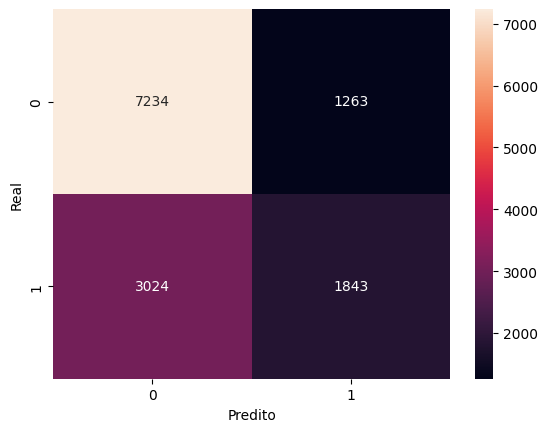

In [48]:
matriz_confusao(y_test, y_pred_xgb_baseline)

#### Árvore de Decisão e Floresta Aleatória

In [15]:
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)

In [48]:
# param_grid_dt = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [3, 5, 7, 10],
#     'min_samples_split': [2, 5, 10]
# }

# param_grid_rf = {
#     'n_estimators': [10, 50, 100],
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [3, 5, 7, 10],
#     'min_samples_split': [2, 5, 10]
# }

param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'bootstrap': [True, False]
}

In [49]:
grid_search_dt = GridSearchCV(estimator=dt, param_grid=param_grid_dt, cv=cv, n_jobs=-1, verbose=2)
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=cv, n_jobs=-1, verbose=2)

In [ ]:
grid_search_dt.fit(X_train, y_train)

In [ ]:
grid_search_rf.fit(X_train, y_train)

In [53]:
y_pred_dt = grid_search_dt.best_estimator_.predict(X_test)
y_pred_rf = grid_search_rf.best_estimator_.predict(X_test)

In [54]:
print("Melhores parâmetros para Árvore de Decisão:", grid_search_dt.best_params_)
print("Relatório de Classificação para Árvore de Decisão:\n", classification_report(y_test, y_pred_dt))

Melhores parâmetros para Árvore de Decisão: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2}
Relatório de Classificação para Árvore de Decisão:
               precision    recall  f1-score   support

         0.0       0.67      0.87      0.76      8497
         1.0       0.54      0.26      0.35      4867

    accuracy                           0.65     13364
   macro avg       0.61      0.57      0.56     13364
weighted avg       0.63      0.65      0.61     13364



Melhores parâmetros para Árvore de Decisão: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2}

In [56]:
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Acurácia da Árvore de Decisão no conjunto de teste:", accuracy_dt)

precision_dt = precision_score(y_test, y_pred_dt)
print("Precisão da Árvore de Decisão no conjunto de teste:", precision_dt)

recall_dt = recall_score(y_test, y_pred_dt)
print("Recall da Árvore de Decisão no conjunto de teste:", recall_dt)

f1_dt = f1_score(y_test, y_pred_dt)
print("f1_score da Árvore de Decisão no conjunto de teste:", f1_dt)

Acurácia da Árvore de Decisão no conjunto de teste: 0.6502544148458546
Precisão da Árvore de Decisão no conjunto de teste: 0.541186513017499
Recall da Árvore de Decisão no conjunto de teste: 0.2605301006780357
f1_score da Árvore de Decisão no conjunto de teste: 0.35173370319001385


In [57]:
print("Melhores parâmetros para Random Forest:", grid_search_rf.best_params_)
print("Relatório de Classificação para Random Forest:\n", classification_report(y_test, y_pred_rf))

Melhores parâmetros para Random Forest: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 200}
Relatório de Classificação para Random Forest:
               precision    recall  f1-score   support

         0.0       0.69      0.89      0.78      8497
         1.0       0.60      0.29      0.39      4867

    accuracy                           0.67     13364
   macro avg       0.65      0.59      0.58     13364
weighted avg       0.66      0.67      0.64     13364



Melhores parâmetros para Random Forest: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 200}

In [59]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Acurácia Floresta Aleatória:", accuracy_rf)

precisao_rf = precision_score(y_test, y_pred_rf)
print("Precisão Floresta Aleatória:", precisao_rf)

recall_rf = recall_score(y_test, y_pred_rf)
print("Recall Floresta Aleatória:", recall_rf)

f1_rf = f1_score(y_test, y_pred_rf)
print("f1_score Floresta Aleatória:", f1_rf)

Acurácia Floresta Aleatória: 0.6725531278060461
Precisão Floresta Aleatória: 0.6046016190881977
Recall Floresta Aleatória: 0.29155537291966305
f1_score Floresta Aleatória: 0.3934017188799557


In [73]:
feature_names = X.columns
importances_dt = grid_search_dt.best_estimator_.feature_importances_ * 100
importances_rf = grid_search_rf.best_estimator_.feature_importances_ * 100
# for feature_name, importance in zip(feature_names, importances_rf):
#     print(f"{feature_name}: {importance}")

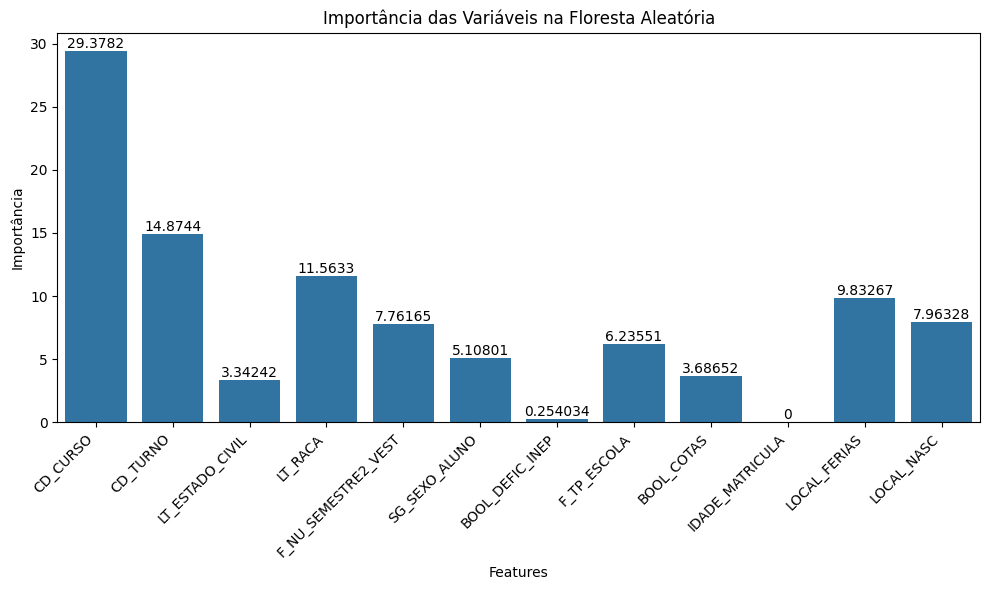

In [77]:
plt.figure(figsize=(10, 6))
vis = sns.barplot(x=feature_names, y=importances_dt)
for container in vis.containers:
        vis.bar_label(container)
plt.title("Importância das Variáveis na Floresta Aleatória")
plt.xlabel("Features")
plt.ylabel("Importância")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

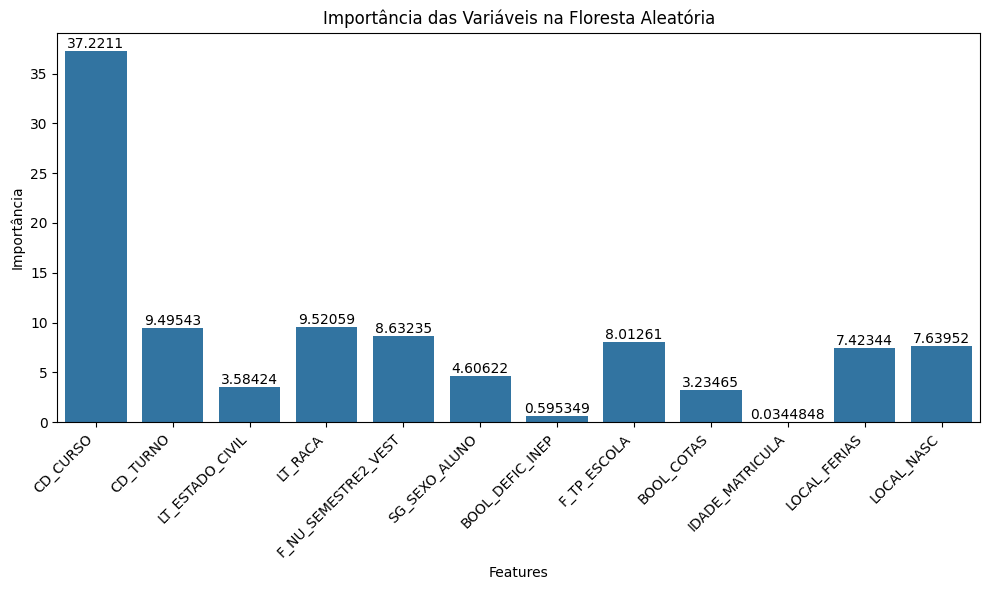

In [76]:
plt.figure(figsize=(10, 6))
vis = sns.barplot(x=feature_names, y=importances_rf)
for container in vis.containers:
        vis.bar_label(container)
plt.title("Importância das Variáveis na Floresta Aleatória")
plt.xlabel("Features")
plt.ylabel("Importância")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### XGBoost

In [80]:
xgb = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

In [83]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0]
}

In [84]:
xgb_grid = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=2)

In [85]:
xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_typ...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7, 10],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.5, 0.8, 1.0]},
             verbose=2)

In [86]:
y_pred_xgb = xgb_grid.best_estimator_.predict(X_test)

In [87]:
print("Melhores parâmetros para XGBoost:", xgb_grid.best_params_)

Melhores parâmetros para XGBoost: {'colsample_bytree': 0.5, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}


In [88]:
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("Acurácia XGBoost:", accuracy_xgb)

precisao_xgb = precision_score(y_test, y_pred_xgb)
print("Precisão XGBoost:", precisao_xgb)

recall_xgb = recall_score(y_test, y_pred_xgb)
print("Recall XGBoost:", recall_xgb)

f1_xgb = f1_score(y_test, y_pred_xgb)
print("f1_score XGBoost:", f1_xgb)

Acurácia XGBoost: 0.684375935348698
Precisão XGBoost: 0.608564737370358
Recall XGBoost: 0.3737415245531128
f1_score XGBoost: 0.46308553971486766


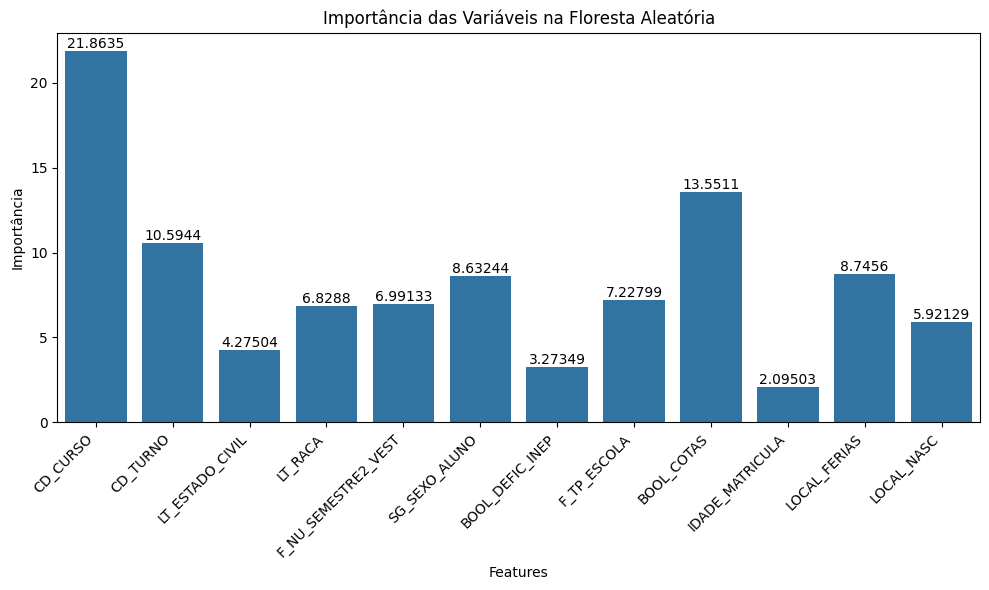

In [131]:
feature_names = X.columns
importances_xgb = xgb_grid.best_estimator_.feature_importances_ * 100

plt.figure(figsize=(10, 6))
vis = sns.barplot(x=feature_names, y=importances_xgb)
for container in vis.containers:
        vis.bar_label(container)
plt.title("Importância das Variáveis na XGBoost")
plt.xlabel("Features")
plt.ylabel("Importância")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Modelo - Gerações completas apenas

In [18]:
df_geracoes_completas = df[df['GERACAO_COMPLETA'] == 1]
df_geracoes_completas.shape[0]

42249

In [152]:
X = df_geracoes_completas.drop(colunas_excluir_ml, axis=1)
y = df_geracoes_completas[target_bool]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [153]:
len(X_train), len(X_test), sum(y_train), sum(y_test)

(33799, 8450, 12110.0, 3028.0)

In [143]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [144]:
dt_gc = DecisionTreeClassifier(random_state=42)
rf_gc = RandomForestClassifier(random_state=42)
xgb_gc = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

In [162]:
param_grid_dt_gc = {
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

param_grid_rf_gc = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

param_grid_xgb_gc = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0]
}

In [149]:
grid_search_dt_gc = GridSearchCV(estimator=dt_gc, param_grid=param_grid_dt_gc, cv=cv, n_jobs=-1, verbose=2)
grid_search_rf_gc = GridSearchCV(estimator=rf_gc, param_grid=param_grid_rf_gc, cv=cv, n_jobs=-1, verbose=2)
grid_search_xgb_gc = GridSearchCV(estimator=xgb_gc, param_grid=param_grid_xgb_gc, cv=cv, n_jobs=-1, verbose=2)

#### Baseline

In [ ]:
dt_gc_baseline = DecisionTreeClassifier(random_state=42)
rf_gc_baseline = RandomForestClassifier(random_state=42)
xgb_gc_baseline = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

dt_gc_baseline.fit(X_train, y_train)
rf_gc_baseline.fit(X_train, y_train)
xgb_gc_baseline.fit(X_train, y_train)

y_pred_dt_gc_baseline = dt_gc_baseline.predict(X_test)
y_pred_rf_gc_baseline = rf_gc_baseline.predict(X_test)
y_pred_xgb_gc_baseline = xgb_gc_baseline.predict(X_test)

In [176]:
accuracy_dt_gc_baseline = accuracy_score(y_test, y_pred_dt_gc_baseline)
print("Acurácia Árvore de Decisão Gerações Completas Baseline:", accuracy_dt_gc_baseline)

precisao_dt_gc_baseline = precision_score(y_test, y_pred_dt_gc_baseline)
print("Precisão Árvore de Decisão Gerações Completas Baseline:", precisao_dt_gc_baseline)

recall_dt_gc_baseline = recall_score(y_test, y_pred_dt_gc_baseline)
print("Recall Árvore de Decisão Gerações Completas Baseline:", recall_dt_gc_baseline)

f1_dt_gc_baseline = f1_score(y_test, y_pred_dt_gc_baseline)
print("f1_score Árvore de Decisão Gerações Completas Baseline:", f1_dt_gc_baseline)

Acurácia Árvore de Decisão Gerações Completas Baseline: 0.641775147928994
Precisão Árvore de Decisão Gerações Completas Baseline: 0.5002114164904863
Recall Árvore de Decisão Gerações Completas Baseline: 0.39068692206076616
f1_score Árvore de Decisão Gerações Completas Baseline: 0.43871685518264414


In [177]:
accuracy_rf_gc_baseline = accuracy_score(y_test, y_pred_rf_gc_baseline)
print("Acurácia Floresta Aleatória Gerações Completas Baseline:", accuracy_rf_gc_baseline)

precisao_rf_gc_baseline = precision_score(y_test, y_pred_rf_gc_baseline)
print("Precisão Floresta Aleatória Gerações Completas Baseline:", precisao_rf_gc_baseline)

recall_rf_gc_baseline = recall_score(y_test, y_pred_rf_gc_baseline)
print("Recall Floresta Aleatória Gerações Completas Baseline:", recall_rf_gc_baseline)

f1_rf_gc_baseline = f1_score(y_test, y_pred_rf_gc_baseline)
print("f1_score Floresta Aleatória Gerações Completas Baseline:", f1_rf_gc_baseline)

Acurácia Floresta Aleatória Gerações Completas Baseline: 0.6539644970414201
Precisão Floresta Aleatória Gerações Completas Baseline: 0.5214521452145214
Recall Floresta Aleatória Gerações Completas Baseline: 0.41743725231175693
f1_score Floresta Aleatória Gerações Completas Baseline: 0.46368305209097577


In [178]:
accuracy_xgb_gc_baseline = accuracy_score(y_test, y_pred_xgb_gc_baseline)
print("Acurácia XGBoost Gerações Completas Baseline:", accuracy_xgb_gc_baseline)

precisao_xgb_gc_baseline = precision_score(y_test, y_pred_xgb_gc_baseline)
print("Precisão XGBoost Gerações Completas Baseline:", precisao_xgb_gc_baseline)

recall_xgb_gc_baseline = recall_score(y_test, y_pred_xgb_gc_baseline)
print("Recall XGBoost Gerações Completas Baseline:", recall_xgb_gc_baseline)

f1_xgb_gc_baseline = f1_score(y_test, y_pred_xgb_gc_baseline)
print("f1_score XGBoost Gerações Completas Baseline:", f1_xgb_gc_baseline)

Acurácia XGBoost Gerações Completas Baseline: 0.6959763313609467
Precisão XGBoost Gerações Completas Baseline: 0.6120058565153733
Recall XGBoost Gerações Completas Baseline: 0.4141347424042272
f1_score XGBoost Gerações Completas Baseline: 0.4939925152649203


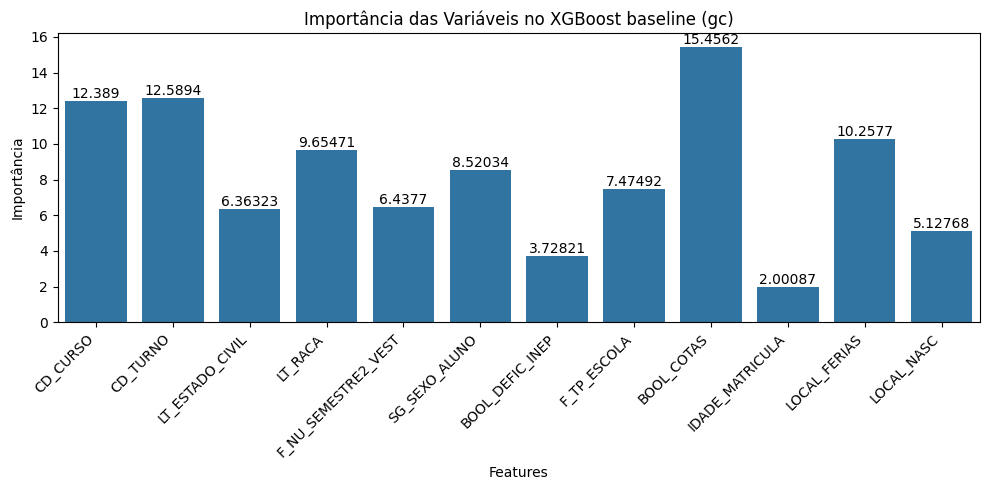

In [179]:
feature_names = X.columns
importances_xgb_gc_baseline = xgb_gc_baseline.feature_importances_ * 100

plt.figure(figsize=(10, 5))
vis = sns.barplot(x=feature_names, y=importances_xgb_gc_baseline)
for container in vis.containers:
        vis.bar_label(container)
plt.title("Importância das Variáveis no XGBoost baseline (gc)")
plt.xlabel("Features")
plt.ylabel("Importância")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Árvore

In [154]:
grid_search_dt_gc.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10, 20]},
             verbose=2)

In [155]:
y_pred_dt_gc = grid_search_dt_gc.best_estimator_.predict(X_test)

In [156]:
print("Melhores parâmetros para Árvore de Decisão:", grid_search_dt_gc.best_params_)
print("Relatório de Classificação para Árvore de Decisão:\n", classification_report(y_test, y_pred_dt_gc))

Melhores parâmetros para Árvore de Decisão: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Relatório de Classificação para Árvore de Decisão:
               precision    recall  f1-score   support

         0.0       0.70      0.87      0.77      5422
         1.0       0.58      0.33      0.42      3028

    accuracy                           0.67      8450
   macro avg       0.64      0.60      0.60      8450
weighted avg       0.66      0.67      0.65      8450



In [157]:
accuracy_dt = accuracy_score(y_test, y_pred_dt_gc)
print("Acurácia da Árvore de Decisão (gc):", accuracy_dt)

precision_dt = precision_score(y_test, y_pred_dt_gc)
print("Precisão da Árvore de Decisão (gc):", precision_dt)

recall_dt = recall_score(y_test, y_pred_dt_gc)
print("Recall da Árvore de Decisão (gc):", recall_dt)

f1_dt = f1_score(y_test, y_pred_dt_gc)
print("f1_score da Árvore de Decisão (gc):", f1_dt)

Acurácia da Árvore de Decisão (gc): 0.6744378698224852
Precisão da Árvore de Decisão (gc): 0.5801968731905037
Recall da Árvore de Decisão (gc): 0.33091149273447823
f1_score da Árvore de Decisão (gc): 0.42145110410094644


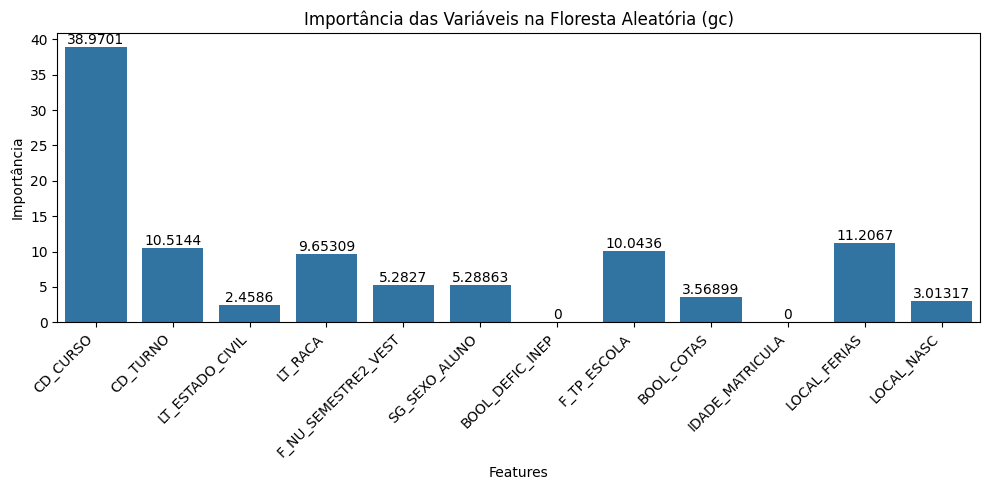

In [167]:
feature_names = X.columns
importances_dt_gc = grid_search_dt_gc.best_estimator_.feature_importances_ * 100

plt.figure(figsize=(10, 5))
vis = sns.barplot(x=feature_names, y=importances_dt_gc)
for container in vis.containers:
        vis.bar_label(container)
plt.title("Importância das Variáveis na Floresta Aleatória (gc)")
plt.xlabel("Features")
plt.ylabel("Importância")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Floresta

In [169]:
grid_search_rf_gc.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10, 20],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [170]:
y_pred_rf_gc = grid_search_rf_gc.best_estimator_.predict(X_test)

In [171]:
print("Melhores parâmetros para Floresta (gc):", grid_search_rf_gc.best_params_)
print("Relatório de Classificação para Floresta (gc):\n", classification_report(y_test, y_pred_rf_gc))

Melhores parâmetros para Floresta (gc): {'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 200}
Relatório de Classificação para Floresta (gc):
               precision    recall  f1-score   support

         0.0       0.70      0.89      0.78      5422
         1.0       0.62      0.32      0.43      3028

    accuracy                           0.69      8450
   macro avg       0.66      0.61      0.61      8450
weighted avg       0.67      0.69      0.66      8450



In [172]:
accuracy_rf = accuracy_score(y_test, y_pred_rf_gc)
print("Acurácia da XGB (gc):", accuracy_rf)

precision_rf = precision_score(y_test, y_pred_rf_gc)
print("Precisão da XGB (gc):", precision_rf)

recall_rf = recall_score(y_test, y_pred_rf_gc)
print("Recall da XGB (gc):", recall_rf)

f1_rf = f1_score(y_test, y_pred_rf_gc)
print("f1_score da XGB (gc):", f1_rf)

Acurácia da XGB (gc): 0.6871005917159764
Precisão da XGB (gc): 0.6212121212121212
Recall da XGB (gc): 0.3249669749009247
f1_score da XGB (gc): 0.42671292281006074


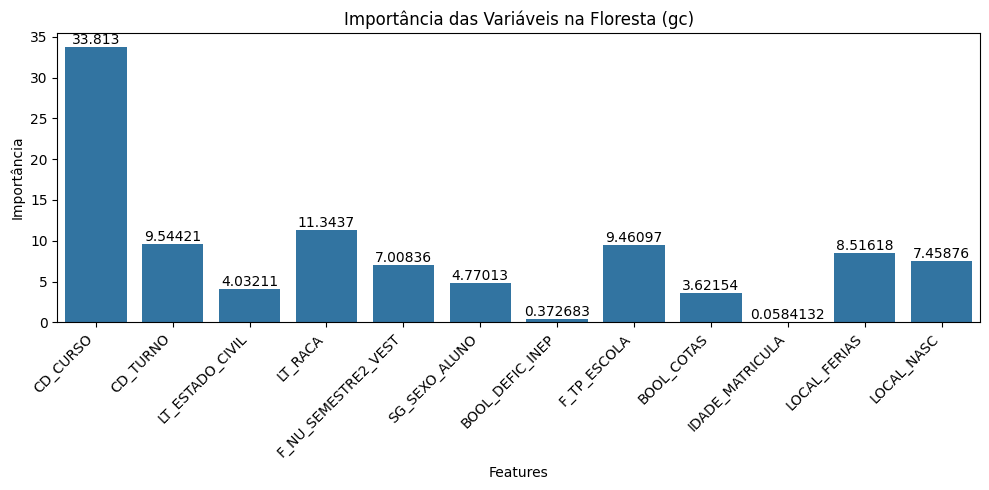

In [173]:
feature_names = X.columns
importances_rf_gc = grid_search_rf_gc.best_estimator_.feature_importances_ * 100

plt.figure(figsize=(10, 5))
vis = sns.barplot(x=feature_names, y=importances_rf_gc)
for container in vis.containers:
        vis.bar_label(container)
plt.title("Importância das Variáveis na Floresta (gc)")
plt.xlabel("Features")
plt.ylabel("Importância")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### XGBoost

In [163]:
grid_search_xgb_gc.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_typ...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [10, 20, 30],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.5, 0.8, 1.0]},
             verbose=2)

In [164]:
y_pred_xgb_gc = grid_search_xgb_gc.best_estimator_.predict(X_test)

In [165]:
print("Melhores parâmetros para XGB:", grid_search_xgb_gc.best_params_)
print("Relatório de Classificação para XGB:\n", classification_report(y_test, y_pred_xgb_gc))

Melhores parâmetros para XGB: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 50, 'subsample': 0.8}
Relatório de Classificação para XGB:
               precision    recall  f1-score   support

         0.0       0.71      0.88      0.79      5422
         1.0       0.63      0.36      0.46      3028

    accuracy                           0.69      8450
   macro avg       0.67      0.62      0.62      8450
weighted avg       0.68      0.69      0.67      8450



In [166]:
accuracy_xgb = accuracy_score(y_test, y_pred_xgb_gc)
print("Acurácia da XGB (gc):", accuracy_xgb)

precision_xgb = precision_score(y_test, y_pred_xgb_gc)
print("Precisão da XGB (gc):", precision_xgb)

recall_xgb = recall_score(y_test, y_pred_xgb_gc)
print("Recall da XGB (gc):", recall_xgb)

f1_xgb = f1_score(y_test, y_pred_xgb_gc)
print("f1_score da XGB (gc):", f1_xgb)

Acurácia da XGB (gc): 0.6946745562130178
Precisão da XGB (gc): 0.6278538812785388
Recall da XGB (gc): 0.3632760898282695
f1_score da XGB (gc): 0.46025104602510464


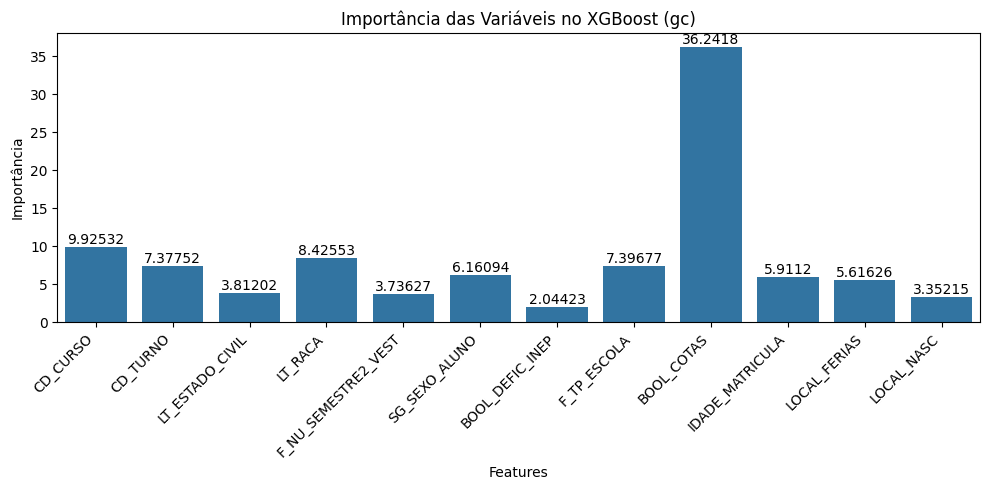

In [168]:
feature_names = X.columns
importances_xgb_gc = grid_search_xgb_gc.best_estimator_.feature_importances_ * 100

plt.figure(figsize=(10, 5))
vis = sns.barplot(x=feature_names, y=importances_xgb_gc)
for container in vis.containers:
        vis.bar_label(container)
plt.title("Importância das Variáveis no XGBoost (gc)")
plt.xlabel("Features")
plt.ylabel("Importância")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Modelo para gerações antigas no treino e gerações mais novas no teste

In [22]:
df_geracoes_completas['NUMERO_GERACAO'].nunique()

16

In [19]:
df_geracoes_completas = df[df['GERACAO_COMPLETA'] == 1]
df_geracoes_completas.shape[0]

42249

In [25]:
X_train = df_geracoes_completas[df_geracoes_completas['NUMERO_GERACAO'] <= 10].drop(colunas_excluir_ml, axis=1)
y_train = df_geracoes_completas[df_geracoes_completas['NUMERO_GERACAO'] <= 10][target_bool]

X_test = df_geracoes_completas[df_geracoes_completas['NUMERO_GERACAO'] > 10].drop(colunas_excluir_ml, axis=1)
y_test = df_geracoes_completas[df_geracoes_completas['NUMERO_GERACAO'] > 10][target_bool]

len(X_train), len(X_test), sum(y_train), sum(y_test)

(31946, 10303, 10671.0, 4467.0)

In [27]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

dt_ga = DecisionTreeClassifier(random_state=42)
rf_ga = RandomForestClassifier(random_state=42)
xgb_ga = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

param_grid_dt_ga = {
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

param_grid_rf_ga = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

param_grid_xgb_ga = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0]
}

grid_search_dt_ga = GridSearchCV(estimator=dt_ga, param_grid=param_grid_dt_ga, cv=cv, n_jobs=-1, verbose=2)
grid_search_rf_ga = GridSearchCV(estimator=rf_ga, param_grid=param_grid_rf_ga, cv=cv, n_jobs=-1, verbose=2)
grid_search_xgb_ga = GridSearchCV(estimator=xgb_ga, param_grid=param_grid_xgb_ga, cv=cv, n_jobs=-1, verbose=2)

#### Baseline

In [30]:
y_pred_ga = np.zeros(len(y_test))

avaliar_modelo(y_test, y_pred_ga)

Acurácia : 0.5664369601087063
Precisão : 0.0
Recall : 0.0
f1_score : 0.0


c:\Users\romul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.5664369601087063, 0.0, 0.0, 0.0)

#### Árvore

In [31]:
grid_search_dt_ga.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10, 20]},
             verbose=2)

In [32]:
y_pred_dt_ga = grid_search_dt_ga.best_estimator_.predict(X_test)

In [33]:
print("Melhores parâmetros para Árvore de Decisão:", grid_search_dt_ga.best_params_)
print("Relatório de Classificação para Árvore de Decisão:\n", classification_report(y_test, y_pred_dt_ga))

Melhores parâmetros para Árvore de Decisão: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Relatório de Classificação para Árvore de Decisão:
               precision    recall  f1-score   support

         0.0       0.59      0.93      0.72      5836
         1.0       0.64      0.15      0.25      4467

    accuracy                           0.60     10303
   macro avg       0.61      0.54      0.49     10303
weighted avg       0.61      0.60      0.52     10303



In [34]:
avaliar_modelo(y_test, y_pred_dt_ga)

Acurácia : 0.5954576336989227
Precisão : 0.6393289841565704
Recall : 0.15357062905753302
f1_score : 0.24765342960288805


(0.5954576336989227,
 0.6393289841565704,
 0.15357062905753302,
 0.24765342960288805)

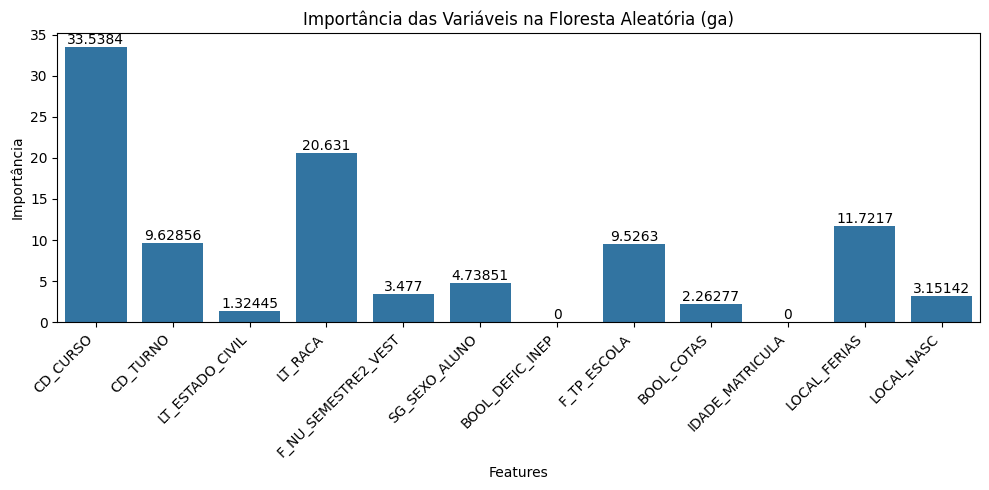

In [35]:
feature_names = X.columns
importances_dt_ga = grid_search_dt_ga.best_estimator_.feature_importances_ * 100

plt.figure(figsize=(10, 5))
vis = sns.barplot(x=feature_names, y=importances_dt_ga)
for container in vis.containers:
        vis.bar_label(container)
plt.title("Importância das Variáveis na Floresta Aleatória (ga)")
plt.xlabel("Features")
plt.ylabel("Importância")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Floresta

In [36]:
grid_search_rf_ga.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10, 20],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [37]:
y_pred_rf_ga = grid_search_rf_ga.best_estimator_.predict(X_test)

In [39]:
print("Melhores parâmetros para Floresta (ga):", grid_search_rf_ga.best_params_)
print("Relatório de Classificação para Floresta (ga):\n", classification_report(y_test, y_pred_rf_ga))

Melhores parâmetros para Floresta (ga): {'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 200}
Relatório de Classificação para Floresta (ga):
               precision    recall  f1-score   support

         0.0       0.58      0.98      0.73      5836
         1.0       0.74      0.06      0.12      4467

    accuracy                           0.58     10303
   macro avg       0.66      0.52      0.42     10303
weighted avg       0.65      0.58      0.46     10303



In [38]:
avaliar_modelo(y_test, y_pred_rf_ga)

Acurácia : 0.584295836164224
Precisão : 0.7383419689119171
Recall : 0.06380120886501008
f1_score : 0.11745312178034206


(0.584295836164224,
 0.7383419689119171,
 0.06380120886501008,
 0.11745312178034206)

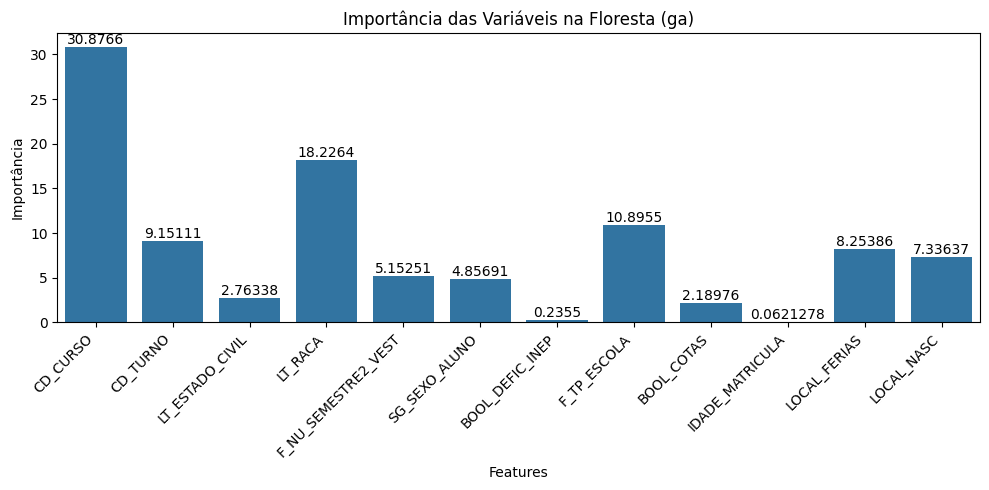

In [40]:
feature_names = X.columns
importances_rf_ga = grid_search_rf_ga.best_estimator_.feature_importances_ * 100

plt.figure(figsize=(10, 5))
vis = sns.barplot(x=feature_names, y=importances_rf_ga)
for container in vis.containers:
        vis.bar_label(container)
plt.title("Importância das Variáveis na Floresta (ga)")
plt.xlabel("Features")
plt.ylabel("Importância")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### XGBoost

In [41]:
grid_search_xgb_ga.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_typ...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [10, 20, 30],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.5, 0.8, 1.0]},
             verbose=2)

In [42]:
y_pred_xgb_ga = grid_search_xgb_ga.best_estimator_.predict(X_test)

In [43]:
print("Melhores parâmetros para XGB:", grid_search_xgb_ga.best_params_)
print("Relatório de Classificação para XGB:\n", classification_report(y_test, y_pred_xgb_ga))

Melhores parâmetros para XGB: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 50, 'subsample': 0.5}
Relatório de Classificação para XGB:
               precision    recall  f1-score   support

         0.0       0.59      0.97      0.73      5836
         1.0       0.72      0.12      0.20      4467

    accuracy                           0.60     10303
   macro avg       0.65      0.54      0.47     10303
weighted avg       0.65      0.60      0.50     10303



In [44]:
avaliar_modelo(y_test, y_pred_xgb_ga)

Acurácia : 0.5977870523148597
Precisão : 0.7209302325581395
Recall : 0.11797627042758004
f1_score : 0.2027702962677953


(0.5977870523148597,
 0.7209302325581395,
 0.11797627042758004,
 0.2027702962677953)

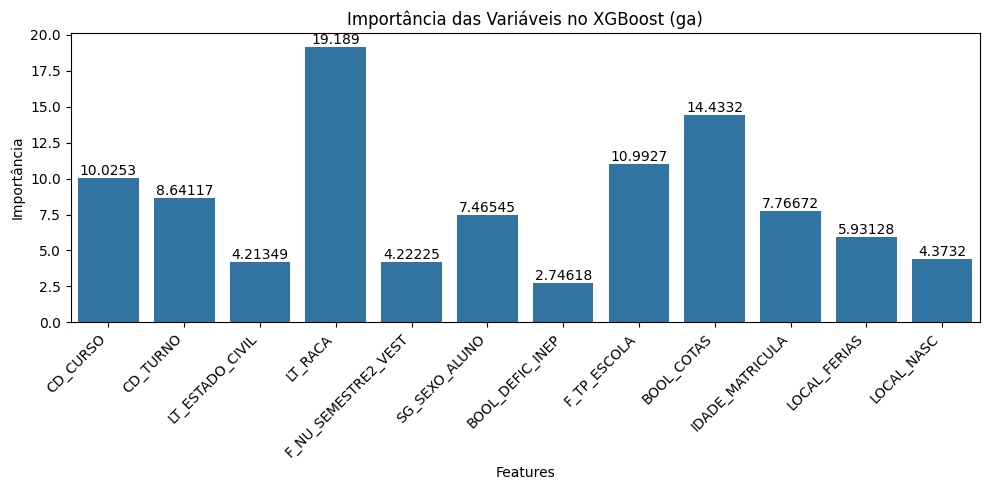

In [45]:
feature_names = X.columns
importances_xgb_ga = grid_search_xgb_ga.best_estimator_.feature_importances_ * 100

plt.figure(figsize=(10, 5))
vis = sns.barplot(x=feature_names, y=importances_xgb_ga)
for container in vis.containers:
        vis.bar_label(container)
plt.title("Importância das Variáveis no XGBoost (ga)")
plt.xlabel("Features")
plt.ylabel("Importância")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Modelo para um Centro

In [14]:
df_ctc = df[df['SG_CENTRO'] == 'CTC']

X = df_ctc.drop(colunas_excluir_ml, axis=1)
y = df_ctc[target_bool]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

len(X_train), len(X_test), sum(y_train), sum(y_test)

(12650, 3163, 4741.0, 1186.0)

In [15]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#### Baseline

In [29]:
dt_baseline = DecisionTreeClassifier(random_state=42)
rf_baseline = RandomForestClassifier(random_state=42)
xgb_baseline = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

dt_baseline.fit(X_train, y_train)
rf_baseline.fit(X_train, y_train)
xgb_baseline.fit(X_train, y_train)

y_pred_dt_baseline = dt_baseline.predict(X_test)
y_pred_rf_baseline = rf_baseline.predict(X_test)
y_pred_xgb_baseline = xgb_baseline.predict(X_test)

array([[133,  11],
       [ 45,   5]], dtype=int64)

In [19]:
avaliar_modelo(y_test, y_pred_dt_baseline)

Acurácia : 0.6127094530509011
Precisão : 0.4785005512679162
Recall : 0.36593591905564926
f1_score : 0.4147157190635452


(0.6127094530509011,
 0.4785005512679162,
 0.36593591905564926,
 0.4147157190635452)

In [20]:
avaliar_modelo(y_test, y_pred_rf_baseline)

Acurácia : 0.6247233638950364
Precisão : 0.4994675186368477
Recall : 0.3954468802698145
f1_score : 0.44141176470588234


(0.6247233638950364,
 0.4994675186368477,
 0.3954468802698145,
 0.44141176470588234)

In [21]:
avaliar_modelo(y_test, y_pred_xgb_baseline)

Acurácia : 0.6560227631994942
Precisão : 0.5609452736318408
Recall : 0.3802698145025295
f1_score : 0.45326633165829144


(0.6560227631994942,
 0.5609452736318408,
 0.3802698145025295,
 0.45326633165829144)

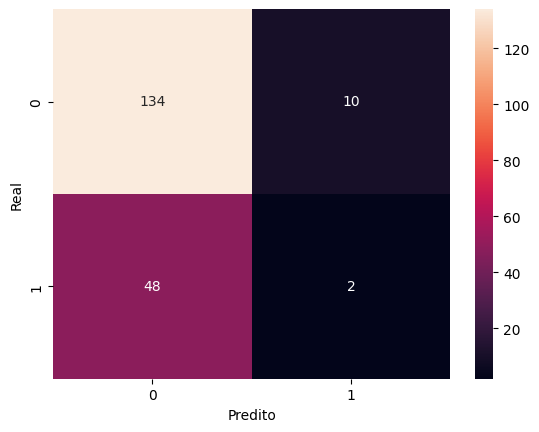

In [32]:
matriz_confusao(y_test, y_pred_xgb_baseline)

### Modelo para um único curso

In [22]:
df_ctc = df[df['CD_CURSO'] == 26]

X = df_ctc.drop(colunas_excluir_ml, axis=1)
y = df_ctc[target_bool]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

len(X_train), len(X_test), sum(y_train), sum(y_test)

(776, 194, 201.0, 50.0)

In [23]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Baseline

In [24]:
dt_baseline = DecisionTreeClassifier(random_state=42)
rf_baseline = RandomForestClassifier(random_state=42)
xgb_baseline = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

dt_baseline.fit(X_train, y_train)
rf_baseline.fit(X_train, y_train)
xgb_baseline.fit(X_train, y_train)

y_pred_dt_baseline = dt_baseline.predict(X_test)
y_pred_rf_baseline = rf_baseline.predict(X_test)
y_pred_xgb_baseline = xgb_baseline.predict(X_test)

In [25]:
avaliar_modelo(y_test, y_pred_dt_baseline)

Acurácia : 0.711340206185567
Precisão : 0.3125
Recall : 0.1
f1_score : 0.15151515151515152


(0.711340206185567, 0.3125, 0.1, 0.15151515151515152)

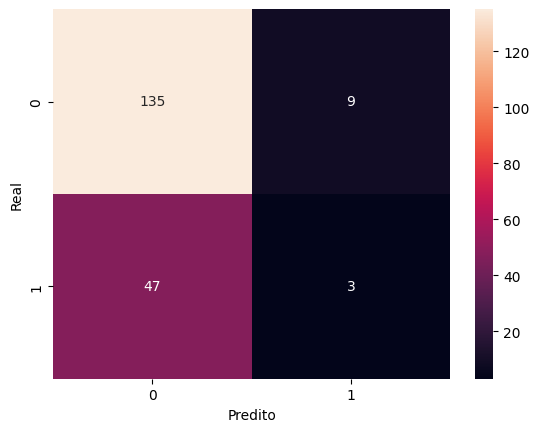

In [35]:
matriz_confusao(y_test, y_pred_rf_baseline)

In [26]:
avaliar_modelo(y_test, y_pred_rf_baseline)

Acurácia : 0.711340206185567
Precisão : 0.25
Recall : 0.06
f1_score : 0.0967741935483871


(0.711340206185567, 0.25, 0.06, 0.0967741935483871)

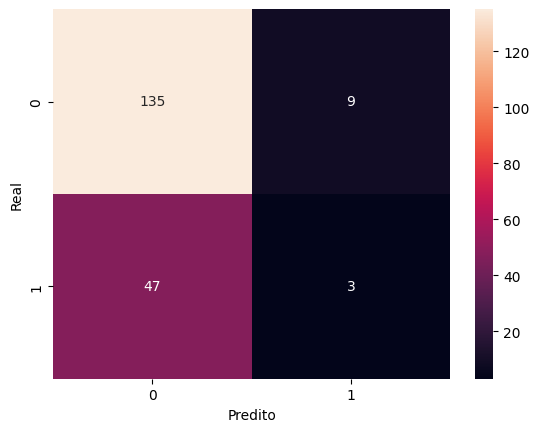

In [34]:
matriz_confusao(y_test, y_pred_rf_baseline)

In [27]:
avaliar_modelo(y_test, y_pred_xgb_baseline)

Acurácia : 0.7010309278350515
Precisão : 0.16666666666666666
Recall : 0.04
f1_score : 0.06451612903225806


(0.7010309278350515, 0.16666666666666666, 0.04, 0.06451612903225806)

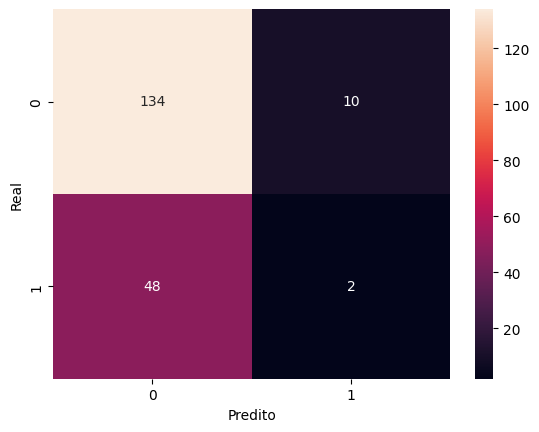

In [33]:
matriz_confusao(y_test, y_pred_xgb_baseline)

### Oversampling

In [103]:
X = df.drop(colunas_excluir_ml, axis=1)
y = df[target_bool]

In [104]:
len(X)

66820

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
len(X_train), len(X_test)

(53456, 13364)

In [106]:
X_train_res, y_train_res = oversample(X_train, y_train)
len(X_train_res)

67980

In [110]:
y_train_res.value_counts()

BOOL_ST_ALUNO
0.0    33990
1.0    33990
Name: count, dtype: int64

In [108]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

dt_res = DecisionTreeClassifier(random_state=42)
rf_res = RandomForestClassifier(random_state=42)
xgb_res = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

param_grid_dt_res = {
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

param_grid_rf_res = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

param_grid_xgb_res = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0]
}

grid_search_dt_res = GridSearchCV(estimator=dt_res, param_grid=param_grid_dt_res, cv=cv, n_jobs=-1, verbose=2)
grid_search_rf_res = GridSearchCV(estimator=rf_res, param_grid=param_grid_rf_res, cv=cv, n_jobs=-1, verbose=2)
grid_search_xgb_res = GridSearchCV(estimator=xgb_res, param_grid=param_grid_xgb_res, cv=cv, n_jobs=-1, verbose=2)

#### Baseline

In [109]:
y_pred_res = np.zeros(len(y_test))

avaliar_modelo(y_test, y_pred_res)

Acurácia : 0.6358126309488177
Precisão : 0.0
Recall : 0.0
f1_score : 0.0


c:\Users\romul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.6358126309488177, 0.0, 0.0, 0.0)